# modules import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

### 현재 gpu 설정

In [2]:
torch.cuda.is_available()

True

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") #쿠다 쓸수 있으면 쿠다, 아니면 cpu

In [4]:
device

device(type='cuda')

# 전처리 설정

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 데이터 로드 및 확인

In [6]:
#trainset 과 testset ㄱㄱ
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


In [7]:
#데이터 로더
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)  #cifar는 조금 복잡하니 배치사이즈는 4로 설정
test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [8]:
#미리 클래스들 정의
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

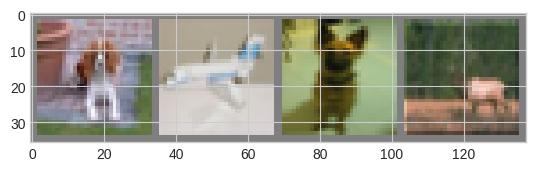

dog   plane dog   deer 


In [11]:
#이미지 확인
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy() #넘파이 이미지로 변환
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# 신경망 구성

In [12]:
#유명한CNN 구조인, LeNet-5 와 유사한 구조의 신경망 (원래 보통 LeNET, Alexnet resnet 등을 참고한다)

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, 5) #입력채널 3개(RGB), 필터 6개, 크기 5X5
    self.pool = nn.MaxPool2d(2, 2) #2X2 맥스풀링
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10) #CIFAR10 즉, 10개 클래스

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net().to(device) #cuda로 보내주기

# 손실함수와 옵티마이저

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#모델 학습

In [14]:
#epoch=2로 설정
for epoch in range(2):
  running_loss = 0.0
  for i , data in enumerate(train_loader, 0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('epoch: {}, batch: {}, loss: {}'.format(epoch+1, i+1, running_loss/2000))
      running_loss = 0.0

epoch: 1, batch: 2000, loss: 2.182470785975456
epoch: 1, batch: 4000, loss: 1.822968791127205
epoch: 1, batch: 6000, loss: 1.6619971184134483
epoch: 1, batch: 8000, loss: 1.5824249663352967
epoch: 1, batch: 10000, loss: 1.5191469688639045
epoch: 1, batch: 12000, loss: 1.4746764641553163
epoch: 2, batch: 2000, loss: 1.424733595620841
epoch: 2, batch: 4000, loss: 1.3657629105001687
epoch: 2, batch: 6000, loss: 1.3429346446357668
epoch: 2, batch: 8000, loss: 1.3297513238191605
epoch: 2, batch: 10000, loss: 1.304671960912645
epoch: 2, batch: 12000, loss: 1.2833094654679298


# 모델 저장 및 로드

In [15]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

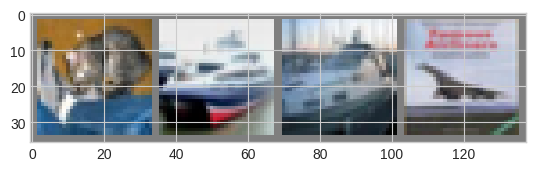

	cat 	ship 	ship 	plane


In [20]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(classes[labels[j]]) for j in range(4)))

- 아래와 같이, 그림에 대해 레이블을 잘 예측하는 것을 볼 수 있다.

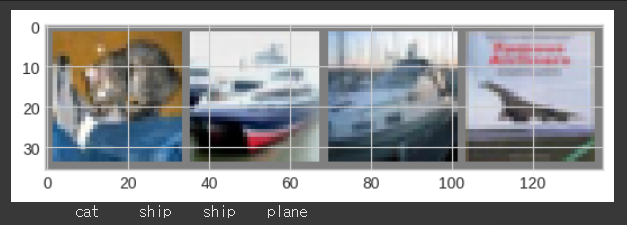

In [21]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH)) #불러오기

<All keys matched successfully>

# 모델 테스트

In [22]:
outputs = net(images.to(device))

In [23]:
_, predicted = torch.max(outputs, 1)
print(' '.join('\t{}'.format(classes[predicted[j]]) for j in range(4)))
#위의 car , ship, ship, plane 의 답과 좀 벗어나는 것을 확인할 수 있다

	cat 	ship 	plane 	ship


In [24]:
#테스트 점수 계산 (no_grad() 필수)
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(100 * correct / total)
  #학습을 많이 시키지 않았기 때문에 .. 54점 나옴

54.79


### 어떤 것을 잘 분류하고, 어떤 것을 잘 못했는지 확인해보자
- 각 10개의 레이블마다 어떤걸 잘 맞추고 못 맞추는지 확인

In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print('accuracy of {}: {}%'.format(classes[i], 100 * class_correct[i] / class_total[i]))

accuracy of plane: 62.4%
accuracy of car: 58.0%
accuracy of bird: 25.4%
accuracy of cat: 23.6%
accuracy of deer: 52.8%
accuracy of dog: 54.6%
accuracy of frog: 72.9%
accuracy of horse: 67.4%
accuracy of ship: 62.8%
accuracy of truck: 68.0%
